# Faster-RCNN Model Implemented using PyTorch

***

**Author:** Shane Cooke

**Date:** 30 Sept 2022

**References:**
* https://medium.com/fullstackai/how-to-train-an-object-detector-with-your-own-coco-dataset-in-pytorch-319e7090da5
* https://towardsdatascience.com/train-mask-rcnn-net-for-object-detection-in-60-lines-of-code-9b6bbff292c3
* https://towardsdatascience.com/how-to-use-datasets-and-dataloader-in-pytorch-for-custom-text-data-270eed7f7c00
* https://www.kaggle.com/code/abhishek/train-your-own-mask-rcnn/notebook

***

## Imports & Data Preparation

#### Google Colab

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#cd drive/MyDrive/MastersProject/Code/

#### Install Dependencies

In [ ]:
#!pip install albumentations==0.4.6
#!pip install pycocotools --quiet

# Clone TorchVision repo and copy helper files
#!git clone https://github.com/pytorch/vision.git
#%cd vision
#!git checkout v0.3.0
#%cd ..
#!cp vision/references/detection/utils.py ./
#!cp vision/references/detection/transforms.py ./
#!cp vision/references/detection/coco_eval.py ./
#!cp vision/references/detection/engine.py ./
#!cp vision/references/detection/coco_utils.py ./

#### Imports

In [1]:
# Import Torch Libraries
import torch
import torchvision
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter

# Import Useful Libraries
import os
import utils
import numpy as np
import transforms as T
from engine import evaluate

# Import Image/File Work
from PIL import Image
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

#### Defining Input/Output Files & Directories

In [3]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, imSize, imDir, imNames, annots, transforms=None):
        self.height = imSize[0]
        self.width = imSize[1]
        self.imDir = imDir
        self.imNames = imNames
        self.annots = annots
        self.transform = transforms
    
    def __getitem__(self, index):
        image_name = self.imNames[index]
        image_path = f"{self.imDir}{image_name}"

        image = Image.open(image_path).convert('RGB')
        w, h = image.size
        image = image.resize((self.width, self.height), resample=Image.Resampling.BILINEAR)

        for item in self.annots['images']:
            if item['file_name'] == image_name:
                imageID = item['id']
                break

        boxes = []
        area = []
        iscrowd = []
        labels = []
        
        for annotation in self.annots['annotations']:
            if annotation['image_id'] == imageID:
                xmin = annotation['bbox'][0] * self.width/w
                ymin = annotation['bbox'][1] * self.height/h
                xmax = xmin + annotation['bbox'][2] * self.width/w
                ymax = ymin + annotation['bbox'][3] * self.height/h
                
                # Append Values to Arrays
                area.append(annotation['area'])
                iscrowd.append(annotation['iscrowd'])
                labels.append(annotation['category_id'])
                boxes.append((xmin, ymin, xmax, ymax))

        # Transform data into Tensor Format
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        imageID = torch.as_tensor(imageID, dtype=torch.int64) # torch.tensor([imageID])
        area = torch.as_tensor(area, dtype=torch.float32)
        iscrowd = torch.as_tensor(iscrowd, dtype=torch.int64)
        
        targets = {}
        targets['boxes'] = boxes
        targets['labels'] = labels
        targets['image_id'] = imageID
        targets['area'] = area
        targets['iscrowd'] = iscrowd

        if self.transform is not None:
            image, targets = self.transform(image, targets)

        return image, targets

    def __len__(self):
        return len(self.imNames)


In [4]:
def get_transform():
    transforms = []
    transforms.append(T.ToTensor())
    return T.Compose(transforms)

#### Testing Data Loader

In [15]:
classes = ('NonOverfilled', 'Overfilled')
ds = "HRI" # ASL or HRI

image_path =  f'./Dataset/{ds}/Control/Test/'
annot_path = f'./Dataset/{ds}/split_test.json'

jpg_files = [pos_jpg for pos_jpg in os.listdir(image_path) if pos_jpg.endswith('.jpg')]

with open(annot_path) as json_file:
    test_annotations = json.load(json_file)

imSize = [183, 223]

test_data = Dataset(imSize, image_path, jpg_files, test_annotations, get_transform())

batchSize = 6
workers = 2
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=batchSize, shuffle=False, num_workers=workers, collate_fn=utils.collate_fn)

***
## Define Model

In [13]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

model = torch.load('./Outputs/ASL CROP/ASL_CROP.pt')
model.to(device)

cuda


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

***
## Visualise Images

#### Plot Bounding Box on Image

In [7]:
def plot_bbox(image, annots, predicts):

    figure, axis = plt.subplots(1,1)
    figure.set_size_inches(10,10)
    axis.imshow(image)

    for bbox in annots['boxes']:
        x, y, width, height = bbox[0], bbox[1], (bbox[2] - bbox[0]), (bbox[3] - bbox[1])
        box = Rectangle((x,y), width, height, linewidth=1, edgecolor='r', facecolor='none')
        axis.add_patch(box)

    for bbox in predicts['boxes']:
        x, y, width, height = bbox[0], bbox[1], (bbox[2] - bbox[0]), (bbox[3] - bbox[1])
        box = Rectangle((x,y), width, height, linewidth=3, edgecolor='c', facecolor='none')
        axis.add_patch(box)

    #plt.show()
    plt.savefig('./EXAMPLE_PREDICTION.jpg')

#### Filtering Predictions

In [8]:
def filter(predictions):
    threshold = 0.3
    keep = torchvision.ops.nms(predictions['boxes'], predictions['scores'], threshold)

    final_prediction = predictions
    final_prediction['boxes'] = final_prediction['boxes'][keep].cpu()
    final_prediction['labels'] = final_prediction['labels'][keep].cpu()
    final_prediction['scores'] = final_prediction['scores'][keep].cpu()

    return final_prediction

***
## Testing the Model

#### Function for Finding Intersection %

In [10]:
def intersection_boxes(annotated_box, predicted_box):
    x = max(annotated_box[0], predicted_box[0])
    xw = min((annotated_box[0] + annotated_box[2]), (predicted_box[0] + predicted_box[2]))
    y = max(annotated_box[1], predicted_box[1])
    yh = min((annotated_box[1] + annotated_box[3]), (predicted_box[1] + predicted_box[3]))
    w = xw - x
    h = yh - y

    inter_area = w * h
    ann_area = annotated_box[2] * annotated_box[3]
    pre_area = predicted_box[2] * predicted_box[3]

    inter_percent = inter_area / (ann_area + pre_area - inter_area)

    return inter_percent

#### Test One Image

In [16]:
evaluate(model, test_data_loader, device=device)

creating index...
index created!
Test:  [ 0/45]  eta: 0:00:40  model_time: 0.7719 (0.7719)  evaluator_time: 0.0027 (0.0027)  time: 0.8911  data: 0.1009  max mem: 5271
Test:  [44/45]  eta: 0:00:00  model_time: 0.7675 (0.7658)  evaluator_time: 0.0019 (0.0020)  time: 0.7764  data: 0.0066  max mem: 5271
Test: Total time: 0:00:35 (0.7787 s / it)
Averaged stats: model_time: 0.7675 (0.7658)  evaluator_time: 0.0019 (0.0020)
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=

The Bins Annotation is : tensor([[453.8600, 298.8400, 625.4300, 479.9700]])
The Bins Predicts is : tensor([[449.2506, 299.7957, 624.4255, 479.3003]])
The Bins Filtered is : tensor([[449.2506, 299.7957, 624.4255, 479.3003]])
Estimate: tensor([0.9993])
The number of ANNOTATED bins is: 1
The number of PREDICTED bins is: 1
The number of CORRECTLY PREDICTED bins is: 1
The number of MISSED bins is: 0
The number of INCORRECTLY PREDICTED bins is: 0


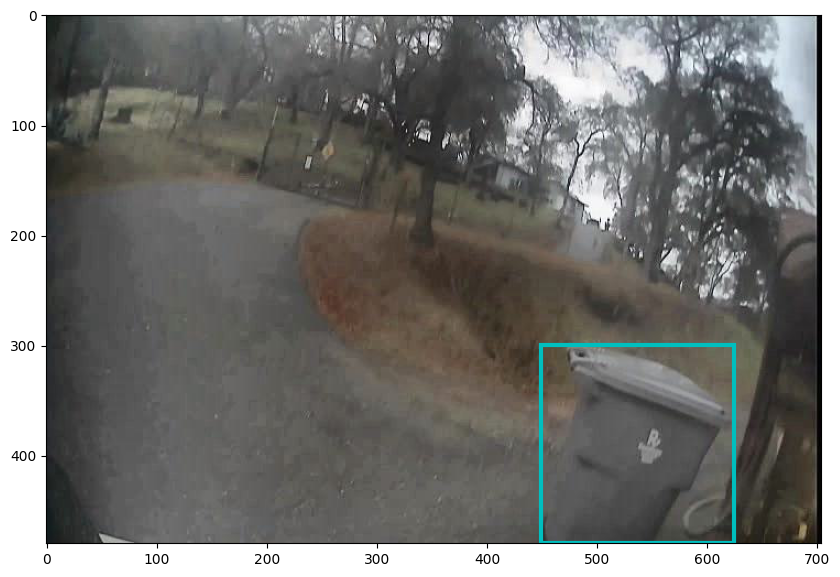

In [17]:
image, annotations = test_data[504]

model.eval()
with torch.no_grad():
    prediction = model([image.to(device)])[0]

filter_pred = filter(prediction)

ann = annotations['boxes']
pre = prediction['boxes']
fil = filter_pred['boxes']
percent = filter_pred['scores']

print(f'The Bins Annotation is : {ann}')
print(f'The Bins Predicts is : {pre}')
print(f'The Bins Filtered is : {fil}')
print(f'Estimate: {percent}')
image = transforms.ToPILImage()(image).convert('RGB')
plot_bbox(image, annotations, filter_pred)

count = 0
annot = annotations['boxes'].tolist()
predict = filter_pred['boxes'].tolist()
annoted_number = len(annot)
predicted_number = len(predict)

# Compare Each Annotated Box with Each Predicted Box
for ann_box in reversed(annot):
    for pre_box in reversed(predict):
        intersection = intersection_boxes(ann_box, pre_box)

        if intersection > 0.9:
            count = count + 1
            annot.remove(ann_box)
            predict.remove(pre_box)

missed = len(annot)
extra = len(predict)

print(f'The number of ANNOTATED bins is: {annoted_number}')
print(f'The number of PREDICTED bins is: {predicted_number}')
print(f'The number of CORRECTLY PREDICTED bins is: {count}')
print(f'The number of MISSED bins is: {missed}')
print(f'The number of INCORRECTLY PREDICTED bins is: {extra}')

#### Test Full Dataset of Images

In [ ]:
anns = 0
pres = 0
count = 0
missed = 0
extra = 0

for item in test_data:
    print('==================================================================')
    image, annotations = item
    ID = annotations['image_id']
    print(f'Image ID: {ID}')

    model.eval()
    with torch.no_grad():
        prediction = model([image.to(device)])[0]
    filter_pred = filter(prediction)

    annot = annotations['boxes'].tolist()
    predict = filter_pred['boxes'].tolist()

    anns = anns + len(annot)
    pres = pres + len(predict)

    # Compare Each Annotated Box with Each Predicted Box
    for ann_box in reversed(annot):
        #print(f'Outer at: {ann_box}')
        for pre_box in reversed(predict):
            #print(f'Inner at: {pre_box}')
            intersection = intersection_boxes(ann_box, pre_box)

            if intersection > 0.9:
                count = count + 1
                #print(f'Tring to remove {ann_box} from {annot}')
                #print(f'Tring to remove {pre_box} from {predict}')
                annot.remove(ann_box)
                predict.remove(pre_box)

    missed = missed + len(annot)
    extra = extra + len(predict)

print(f'The number of ANNOTATED bins is: {annoted_number}')
print(f'The number of PREDICTED bins is: {predicted_number}')
print(f'The number of CORRECTLY PREDICTED bins is: {count}')
print(f'The number of MISSED bins is: {missed}')
print(f'The number of INCORRECTLY PREDICTED bins is: {extra}')

In [ ]:
image, annots = test_data[2]

model.eval()
with torch.no_grad():
    prediction = model([image.to(device)])[0]
    print(prediction)

filter_pred = filter(prediction)

print(filter_pred)

image = transforms.ToPILImage()(image).convert('RGB')
plot_bbox(image, prediction)